# Proyecto 1
        
```
Olivares Castillo José Luis
Facultad de Ingeniería, UNAM
Temas Selectos de Tecnologías del lenguaje
Semestre 2018-1
```

# Descripción

Este trabajo es una tarea de aprendizaje supervisado que consiste en la clasificación de tweets en idioma español en dos clases:
* Positivos
* Negativos

# Dependencias

* [Scikit-learn](http://scikit-learn.org/stable/)
* [Numpy](http://www.numpy.org/)
* [Pandas](https://pandas.pydata.org/)
* [NLTK](http://www.nltk.org/)
* [stop_words](https://pypi.python.org/pypi/stop-words)
* [snowballstemmer](https://pypi.python.org/pypi/snowballstemmer)
* [matplotlib](https://matplotlib.org/)


In [1]:
# -*- coding: utf-8 -*-
"""
    @author: jose 
    FI UNAM
    Created on Thu Oct  26 21:22:06 2017
"""

from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import TweetTokenizer
import os
import numpy as np
import pandas as pd
from stop_words import get_stop_words
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import snowballstemmer
import matplotlib.pyplot as plt
%matplotlib inline

# Semilla para reproducibilidad de los experimentos

In [2]:
np.random.seed(42)

# Descripción de datasets

Se utilizan dos datasets que fueron etiquetados manualmente a partir de  dos clases para determinar si eran positivos o negativos. Ambos contienen tweets escritos en español que fueron emitidos durante diciembre de 2011 a enero de 2012. Existen pocas muestras de tweets que están escritos en inglés


Los tweets están en un formato de etiqueta-tweet, donde la etiqueta 1 corresponde a tweets positivos y 2 a tweets negativos, i.e.:

<table>
  <tr>
    <th>Etiqueta</th>
    <th>Tweet</th>
  </tr>
  <tr>
    <td>1</td>
    <td>un gustazooo encontrar gente bonita y buena onda como @cerezasyhongos por aca :)</td>
  </tr>
  <tr>
    <td>2</td>
    <td>:( Extrañaré muchas cosas de aquí y algunas ni siquiera son del trabajo :(</td>
  </tr>
</table>

Los datasets se leen desde la carpeta `data` y se almacenan en `dataframes` de [Pandas](https://pandas.pydata.org/).

In [3]:
home = os.getcwd()
os.chdir(home + '/data')
os.getcwd()
names = ["Etiqueta","Tweet"]
pos_tweets = pd.read_csv('true_posi.txt', sep="\t", names=names)
neg_tweets = pd.read_csv('true_negs.txt', sep="\t", names=names)
os.chdir(home)

# Dataset de tweets positivos

In [4]:
print("Número total de tweets con etiqueta positiva:",pos_tweets.__len__())

Número total de tweets con etiqueta positiva: 5496


In [5]:
pos_tweets.head(10)

,Etiqueta,Tweet
0,1,@_FerTf grosera jaja muy amable usted igual de...
1,1,@KarenkaaPanqee wooow!!! ^^!! No me muero sin ...
2,1,@akhs190lo hago para gustarte mas mi amor! :) ...
3,1,"@miriworld Si, por favor (:"
4,1,Hay porfin en mi casita (:
5,1,YA SERA N A V I D A D :)
6,1,@tanhdez Ni muy my ni tan tan... Felicidades T...
7,1,@agusveal @jk_blacksmith @abpise @omarfierrot ...
8,1,@cessleon #YoQuieroParaNavidad salir aunquesea...
9,1,fiesta de pizzas (:


# Dataset de tweets negativos

In [6]:
print("Número total de tweets con etiqueta negativa:",neg_tweets.__len__())

Número total de tweets con etiqueta negativa: 6670


In [7]:
neg_tweets.head(10)

,Etiqueta,Tweet
0,2,Prohibido subir un gramo de aquí a diciembre :(
1,2,BUENO SIGO DEPRIMIDA SIN MI CELULAR Y MI NEXTE...
2,2,@miguelgali11 mikeeeee!! como q estas enfermoo...
3,2,RT @mariowanna83: Esos Reyes no me trajeron mi...
4,2,Perdon es lo unico que puedo pedirte :( Patric...
5,2,Te baje las estrellas de un solo golpe ):
6,2,Pfff... pues ya esta :(
7,2,@Armando_Steeler &gt; hey no soy americanista :(
8,2,soy un diestro con alma de zurdo... dios me ca...
9,2,No quiero sentir hambre :(


# Tamaño de datasets
<table>
<tr>
    <th></th>
    <th># Tweets</th>
  </tr>
  <tr>
    <th>Positivos</th>
    <td>5496</td>
  </tr>
  <tr>
    <th>Negativos</th>
    <td>6670</td>
  </tr>
  <tr>
    <th>Total</th>
    <td>12166</td>
  </tr>
</table>

# Total de tweets

Se concatenan los datasets en sólo un `dataframe` para poder realizar los experimentos.

In [8]:
tweets = pd.concat([pos_tweets,neg_tweets])
print("Número total de tweets:",tweets.__len__())

Número total de tweets: 12166


In [9]:
tweets.head(10)

,Etiqueta,Tweet
0,1,@_FerTf grosera jaja muy amable usted igual de...
1,1,@KarenkaaPanqee wooow!!! ^^!! No me muero sin ...
2,1,@akhs190lo hago para gustarte mas mi amor! :) ...
3,1,"@miriworld Si, por favor (:"
4,1,Hay porfin en mi casita (:
5,1,YA SERA N A V I D A D :)
6,1,@tanhdez Ni muy my ni tan tan... Felicidades T...
7,1,@agusveal @jk_blacksmith @abpise @omarfierrot ...
8,1,@cessleon #YoQuieroParaNavidad salir aunquesea...
9,1,fiesta de pizzas (:


La biblioteca [Pandas](https://pandas.pydata.org/) permite hacer un análisis del dataset, en este caso se agrupan todos los tweets por sus etiquetas y se obtiene lo siguiente:

In [10]:
tweets.groupby('Etiqueta').describe()

Tweet                                                               
         count unique                                                top freq
Etiqueta                                                                     
1         5496   5481  RT @haashoficial: Que tengan una buena y larga...    3
2         6670   6642                                   Me siento mal :(    5

De la tabla anterior podemos observar el total de tweets tanto positivos como negativos, así como los que están repetidos que están en el renglón `top` y la frecuencia con la que se repitieron

# Preprocesamiento del dataset

Para preprocesar los tweets antes de iniciar la etapa de entrenamiento, se realiza lo siguiente:

* Tokenización: La biblioteca de [NLTK](http://www.nltk.org/) tiene una clase dedicada para tokenizar tweets, donde se puede convertir cada token a minúsculas, se eliminan caracteres repetidos i.e. (hooooooola -> hola) y se pueden eliminar los usuarios que estén mencionados dentro del tweet. También permite reconocer emoticonos como :) :( :D :S :* etc.

* Stemming: El stemming se aplica a los tokens para reducir las palabras a su raíz y así evitar tener variaciones de una misma palabra que pudieran afectar el desempeño del algoritmo.

* Listas de paro: Se utilizan listas de paro para eliminar de los tweets signos de puntuación y palabras funcionales que no aportan información relevante al contenido de los tweets.

In [11]:
tknzr = TweetTokenizer(preserve_case=False,       # Convertir a minúsculas
                       reduce_len=True,           # Reducir caracteres repetidos
                       strip_handles=True)        # Mostrar @usuarios

stemmer = snowballstemmer.stemmer('Spanish')

lista_de_paro = ['"',"“","/","(",")","[","]","?","¿","!","¡",
                 "rt",":","…",",","\n","#","@","\t","",".","$",
                 "...","-","🤢","newLineCharacter","|","%","<","=",
                 ">","+","'"]

es_stop = get_stop_words('es')

# `Limpiar` tweets 

In [12]:
def clean_tweet(tweet):
    """
    Eliminar tokens que:
    - Estén dentro de lista_de_paro.
    - Sean ligas.
    - Si es una mención i.e @potus, se cambia por token genérico @usuario.
    """
    return [stemmer.stemWord(_) for _ in tweet 
            if _ not in lista_de_paro
            and not _.startswith(('http', 'htt'))
            and _ not in es_stop]           

In [13]:
clean_tuit = []
for tuit in tweets["Tweet"]:
    clean_tokens = clean_tweet(tknzr.tokenize(tuit))
    clean_tuit.append(' '.join(clean_tokens))

### Se actualiza el dataframe con los tweets preprocesados

In [14]:
tweets["Tweet"] = clean_tuit

# Tweet preprocesados

In [15]:
tweets.groupby('Etiqueta').describe()

Tweet                    
         count unique     top freq
Etiqueta                          
1         5496   5354  hol :)   21
2         6670   6482      :(   30

De la tabla anterior se observa que una vez preprocesados los tweets, los que tienen etiqueta 1 (positiva) se caracterizan por tener "hol :)" y los tweets negativos se caracterizan por tener un emoticon 'triste' :(

# Longitud de tweets

Se añade una columna donde se almacena la longitud de los tweets, esto con el fin de averiguar si la longitud del tweet tiene alguna relación con la clase a la que pertenece.

In [16]:
tweets['Longitud'] = tweets['Tweet'].apply(len)

In [17]:
tweets.head(10)

,Etiqueta,Tweet,Longitud
0,1,groser jaj amabl usted igual descans mañan mue...,63
1,1,wooow ^ ^ muer ir contig :),27
2,1,hag gustart mas amor :) jiji,28
3,1,si favor (:,11
4,1,porfin casit (:,15
5,1,ser n v i d d :),16
6,1,my tan tan felic tanii mand bes fuert abraz :),46
7,1,igual hac fri si mand abraz molest :),37
8,1,#yoquieroparanav sal aunquese camin the walkin...,55
9,1,fiest pizz (:,13


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9432a8e2e8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f9432b0b198>], dtype=object)

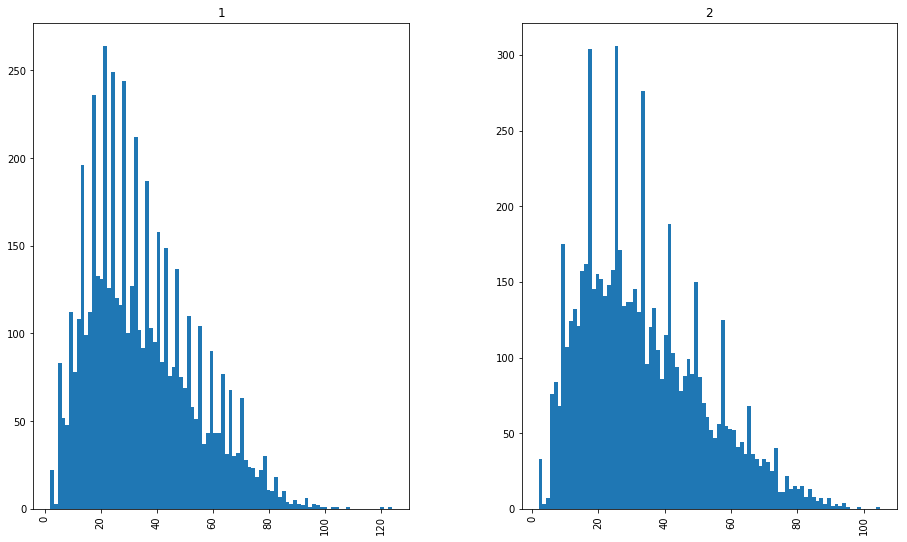

In [18]:
tweets.hist(column='Longitud',by ='Etiqueta',bins=90,figsize = (15,9))

De estas gráficas se observa que los tweets positivos y negativos tienen una distribución similar, sin embargo, la longitud de los tweets positivos llega a superar los 120 caracteres.

# Estadísticas del dataset

In [19]:
tweets.groupby('Etiqueta').describe()

Longitud                                                    
            count       mean        std  min   25%   50%   75%    max
Etiqueta                                                             
1          5496.0  34.808406  18.791860  2.0  20.0  31.0  47.0  124.0
2          6670.0  33.596252  18.186575  2.0  19.0  30.0  45.0  105.0

Se puede observar que los tweets positivos y negativos tienen una media y una desviación estándar muy similar así como los percentiles. Por otra parte, los tweets positivos tienen una longitud máxima de 124 caracteres, mientras que los negativos tienen una máxima de 105 caracteres. 

Con esta información se puede deducir que la longitud de los tweets no es significativa para determinar la clase a la que pertenece.

# Representación vectorial
Para la representación vectorial de los tweets se utiliza la clase `TfidfVectorizer` que está incluida en la biblioteca de [Scikit-learn](http://scikit-learn.org/stable/). Esta clase crea una matriz TF-IDF para los tweets. 

In [20]:
vectorizer = TfidfVectorizer(use_idf=True,               # Usa medida IDF
                             lowercase=True,             # Convierte tokens a minúsculas.
                             strip_accents='ascii',      # Elimina acentos y caracteres especiales
                             smooth_idf=True             # Aplica alisado para prevenir divisiones entre cero.
                             #stop_words=stopset
                             )

In [21]:
X = vectorizer.fit_transform(tweets["Tweet"])
y = tweets["Etiqueta"]

La representación vectorial de los tweets es una matriz dispersa de dimensión:

In [22]:
print(X.shape)

(12166, 10682)


### Matriz dispersa

In [23]:
print(X)

  (0, 4535)	0.378494145746
  (0, 5279)	0.212427252826
  (0, 632)	0.397188425839
  (0, 10077)	0.286631623376
  (0, 4979)	0.25755608953
  (0, 2969)	0.278342123988
  (0, 6060)	0.216210920489
  (0, 6607)	0.415882705932
  (0, 4208)	0.278342123988
  (0, 7557)	0.361539912449
  (1, 10511)	0.648417630031
  (1, 6600)	0.455357638544
  (1, 5204)	0.372666696331
  (1, 2504)	0.483035745604
  (2, 4642)	0.383755932838
  (2, 4603)	0.634597252799
  (2, 6150)	0.290266329294
  (2, 708)	0.342081293486
  (2, 5403)	0.49874197485
  (3, 8995)	0.439888309413
  (3, 4031)	0.898052490248
  (4, 7838)	0.736637807743
  (4, 1894)	0.676287468613
  (5, 8928)	1.0
  (6, 6666)	0.375907293831
  :	:
  (12160, 3710)	0.455055240286
  (12160, 6789)	0.396193856035
  (12161, 1884)	0.618397532516
  (12161, 5822)	0.619856205755
  (12161, 8235)	0.483076366597
  (12162, 8113)	0.308110710131
  (12162, 10239)	0.36803566992
  (12162, 6269)	0.580410221427
  (12162, 7644)	0.406290855763
  (12162, 3412)	0.517367617227
  (12163, 8719)	0.2654

# Evaluación 
La evaluación será una de tipo `Hold-out`.

Se divide el dataset en subconjuntos de entretamiento y prueba, para esto se utiliza la clase [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Los datos se dividen en 75% para el conjunto de entrenamiento y 25% para el conjunto de pruebas.

### Segmentación del dataset

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle = True)

# Método de aprendizaje

El método de aprendizaje utilizado es el algoritmo de [Naive Bayes](http://scikit-learn.org/stable/modules/naive_bayes.html) que está incluido en la biblioteca de Machine Learning [Scikit-learn](http://scikit-learn.org/stable/), en específico una variación de este algoritmo que se llama [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB) que se utiliza generalmente para clasificación de texto.

Se elige este método ya que es escalable y computacionalmente no es muy complejo durante la etapa de entrenamiento.


# Clasificador Naive Bayes


Se instancia el clasificador [Naive Bayes](http://scikit-learn.org/stable/modules/naive_bayes.html) en su versión de [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB) con lo siguientes parámetros:

* `alpha = 0.42`: Constante para aplicar alisado.
* `fit_prior = True`: Para considerar las probabilidades prior de las clases


El valor final de `alpha` se determinó de manera empírica ya que es el valor que encontré que hacía que el clasificador tuviera una mayor exactitud al momento de evaluarlo.

In [25]:
clf = MultinomialNB(alpha=0.42,fit_prior=True)

# Entrenamiento

In [26]:
clf.fit(X_train,y_train)

MultinomialNB(alpha=0.42, class_prior=None, fit_prior=True)

# Performance

In [27]:
print(clf.score(X_test,y_test),"%")

0.77744904668 %


# Predicción de una nueva instancia

Para predecir una nueva instancia, el tweet debe ser un arreglo de tipo `np.array`.Además se debe obtener su representación vectorial para poder evaluar el tweet con el clasificador.

In [28]:
def predict(z):
    new_tweet = np.array([z])
    new_tweet_vector = vectorizer.transform(new_tweet)
    print("Representación vectorial de: ", z)
    print("------" * 10)
    print(new_tweet_vector)
    print("------" * 10)
    print("Evualuación:")
    if clf.predict(new_tweet_vector)[0] == 1:
        print(z," es: positivo")
    else:
        print(z, " es: negativo")

In [29]:
z1 = "Ojalá mañana sea un buen día"
predict(z1)

Representación vectorial de:  Ojalá mañana sea un buen día
------------------------------------------------------------
  (0, 10007)	0.546318232435
  (0, 7036)	0.546318232435
  (0, 6061)	0.546318232435
  (0, 3089)	0.240335983063
  (0, 1566)	0.216443484476
------------------------------------------------------------
Evualuación:
Ojalá mañana sea un buen día  es: positivo


In [30]:
z2 = "Ya es lunes :("
predict(z2)

Representación vectorial de:  Ya es lunes :(
------------------------------------------------------------
  (0, 10574)	1.0
------------------------------------------------------------
Evualuación:
Ya es lunes :(  es: negativo


# Análisis de resultados

In [31]:
from sklearn.metrics import classification_report,confusion_matrix

#### Se obtienen las predicciones de todos los tweets para poder hacer un análisis de los resultados obtenidos

In [32]:
all_predictions = clf.predict(vectorizer.transform(tweets["Tweet"]))
print (all_predictions)

[1 1 1 ..., 2 2 2]


### Matriz de confusión

La matriz de confusión nos da información acerca de los resultados predichos por el clasificador y su verdadera etiqueta. Los valores de la diagonal de esta matriz nos indica el total de instancias que fueron clasificadas correctamente mientras que los valores que no están en la diagonal son instancias que fueron clasificadas como negativas cuando en realidad eran positivas y viceversa.

In [33]:
tn, fp, fn, tp = confusion_matrix(all_predictions,tweets['Etiqueta'],
                                                           labels=[1,2]).ravel()

In [34]:
tn, fp, fn, tp

(4490, 479, 1006, 6191)

In [36]:
print("verdaderos negativos \t{}\nfalsos positivos \t{}\nfalsos negativos \t{}\nverdaderos positivos \t{}\
      ".format(tn, fp, fn, tp))

verdaderos negativos 	4490
falsos positivos 	479
falsos negativos 	1006
verdaderos positivos 	6191      



<table>
  <tr>
    <th colspan="2"></th>
    <th colspan="2">Clase predicha<br></th>
  </tr>
  <tr>
    <th rowspan="3">Clase verdadera<br></th>
    <td>P</td>
    <td>N</td>
  </tr>
  <tr>
    <td>P</td>
    <td>6191</td>
    <td>1006</td>

  </tr>
  <tr>
    <td>N</td>
    <td>479</td>
    <td>4490</td>
  </tr>
</table>

Se observa que los tweets clasificados como falsos positivos son más en comparación con los tweets clasificados como falsos negativos, es decir que al clasificador le es más complicado determinar si un tweet es positivo que si es negativo.

Esto se debe, en parte, a que en el dataset hay más tweets negativos (6670 instancias) que tweets positivos (5496 instancias), lo que implica que haya  una diferencia en el número de instancias de 1174 tweets en el dataset y es posible que este sesgo afecte el desempeño del clasificador para determinar correctamente los tweets de la clase positiva debido a que no tiene tantas instancias positivas como para poder hacer una generalización más adecuada de tweets positivos.

In [73]:
target_names = ['clase positiva','clase negativa']
print (classification_report(tweets['Etiqueta'], all_predictions,target_names=target_names))

                precision    recall  f1-score   support

clase positiva       0.90      0.82      0.86      5496
clase negativa       0.86      0.93      0.89      6670

   avg / total       0.88      0.88      0.88     12166



En la tabla anterior se muestra la precisión, recall y f1-score del algoritmo para clasificar los tweets. Se presenta una diferencia del 9% en el recall de las clases que implica que la clase positiva tiene más 'ruido' y es menos informativa lo que se que transforma en un mayor número de tweets positivos mal clasificados por el algoritmo a diferencia de la clase negativa, debido a que existen mayor número de instancias de esta clase lo que ayuda a que el recall de los tweets negativos sea mayor y que sean clasificados con mayor precisión.

# Conclusiones
Un clasificador Naive-Bayes es un algoritmo que permite escalabilidad y poderoso que no requiere de mucho poder de procesamiento para su entrenamiento y que es usado regularmente en tareas de clasificación de textos.

El dataset, al ser de tweets en idioma español, contiene texto informal y que en algunos casos los tweets contienen ambigüedad, lo que dificulta la tarea de clasificación, por lo tanto, es aconsejable tener en cuenta que los tweets pueden representar, además de sentimientos positivos y negativos, sarcasmo, ironías, etc.

Al haber más instancias de una clase que de otra, el dataset está sesgado y debido a esto tiene más ejemplos sobre tweets negativos que positivos lo que le permite al clasificador obtener una generalización más robusta para determinar si un tweet es negativo, esta diferencia en el número de instancias negativas y positivas representa un 10.36% del tamaño total del dataset lo que se refleja en un mal desempeño al momento de clasificar tweets positivos. Por otra parte, hay que tomar en cuenta que algunas muestra de tweets están escritas en inglés y esto también pudo haber afectado al performance

# Referencias
* https://medium.com/towards-data-science/twitter-sentiment-analysis-on-car-brands-c13d449eb9fc
* https://www.ravikiranj.net/posts/2012/code/how-build-twitter-sentiment-analyzer/
* http://textblob.readthedocs.io/en/latest/advanced_usage.html#sentiment-analyzers
* https://marcobonzanini.com/2015/05/17/mining-twitter-data-with-python-part-6-sentiment-analysis-basics/
* http://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/
* https://dev.to/rodolfoferro/sentiment-analysis-on-trumpss-tweets-using-python-
* http://adataanalyst.com/scikit-learn/countvectorizer-sklearn-example/
* http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html